In [1]:
import pandas as pd
import numpy as np
import parameters as P
import sensitivity_parameters as SP
import helper_functions as hf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
io_data = pd.read_csv(P.io_table_dollars_path)

In [4]:
cost = hf.csv_dict_list(P.cost_impact_path)

In [5]:
y = {}
for item in cost.keys():
    y.update({item:0})

In [6]:
m = {} 
for scenario in P.scenario_range:
    new_data = np.zeros([7,3])
    m[scenario] = pd.DataFrame(new_data, columns=P.selectivity, index=P.processes)

In [7]:
for selectivity in P.selectivity:
    for scenario in P.scenario_range:
        y["lysine.us.kg"] = cost["lysine.us.kg"] * (SP.other_params[selectivity]['chlys_amount'][scenario] * 
                            SP.common_params['chlys_percent'][scenario]) 
        # 58% lysine + 42% ChOH for Chylys production (Stoichiometry) 
        y["cholinium.hydroxide.kg"] = (cost["cholinium.hydroxide.kg"] * 
                                       SP.other_params[selectivity]['chlys_amount'][scenario] * 
                                       SP.common_params['cholinium_percent'][scenario])  
        # 58% lysine + 42% ChOH for Chylys production (Stoichiometry) 
        y["cellulase.kg"] = cost["cellulase.kg"] * SP.common_params['enzyme'][scenario]
        y["csl.kg"] = cost["csl.kg"] * SP.other_params[selectivity]['csl.kg'][scenario]
        y["farmedstover.kg"] = cost["farmedstover.kg"] * SP.other_params[selectivity]['feedstock'][scenario]  
        y["dap.kg"] = cost["dap.kg"] * SP.other_params[selectivity]['dap.kg'][scenario] 
        y["h2so4.kg"] = cost["h2so4.kg"] * SP.other_params[selectivity]['h2so4.kg'][scenario]
        y["naturalgas.MJ"] = cost["naturalgas.MJ"] * (hf.FuelConvertMJ(
                            SP.other_params[selectivity]['ng_input_stream_mass_ww_kg'][scenario], "naturalgas","kg"))
        y["rail.mt_km"] = (cost["rail.mt_km"] * (SP.other_params[selectivity]['chlys_amount'][scenario]/1000) * 
                        SP.common_params['chlys_rail_mt_km'][scenario] +
                            cost["rail.mt_km"] * (
                                P.etoh_feed_stream_mass_kg/1000 * SP.common_params['etoh_distribution_rail'][scenario])) 
        y["flatbedtruck.mt_km"] = (cost["flatbedtruck.mt_km"] * (
                (SP.other_params[selectivity]['chlys_amount'][scenario]/1000) * 
                    SP.common_params['chlys_flatbedtruck_mt_km'][scenario]) +
                        cost["flatbedtruck.mt_km"] * (P.etoh_feed_stream_mass_kg/1000 * (
                            SP.common_params['etoh_distribution_truck'][scenario])))
        y["electricity.{}.kWh".format(P.facility_electricity)] = (
            cost["electricity.{}.kWh".format(P.facility_electricity)] * (
                SP.other_params[selectivity]['electricity_requirements'][scenario]))
        y["hcl.kg"] = cost["hcl.kg"] * SP.other_params[selectivity]['hcl.kg'][scenario]

        biorefinery_direct_ghg = hf.FuelCO2kg(hf.FuelConvertMJ(
                SP.other_params[selectivity]['ng_input_stream_mass_ww_kg'][scenario],"naturalgas","kg"), "naturalgas")

        results_kg_co2e = hf.TotalGHGEmissions(io_data, y, cost, 
                                               biorefinery_direct_ghg, P.combustion_direct_ghg)
        
        results_kg_co2e_dict = results_kg_co2e.set_index('products')['ghg_results_kg'].to_dict()

        hf.AggregateResults(m, results_kg_co2e_dict, selectivity, scenario)
        
        m[scenario][selectivity] = m[scenario][selectivity] * 1000/27 # converting kg per kg results to g per MJ

In [8]:
m['avg']

,iHG-Projected,iHG-Current,waterwash
Farming,2.903830,2.903830,3.379564
Transportation,3.683544,4.475926,5.472493
Petroleum,2.182441,2.870289,5.800505
Electricity,9.505824,18.782255,41.253173
Chemicals_And_Fertilizers,9.054613,20.188270,18.056143
Direct,0.000000,0.000000,94.041719
Other,0.407407,0.777778,0.851852


In [10]:
n = {} 
for scenario in P.scenario_range:
    n_new_data = np.zeros([3,3])
    n = pd.DataFrame(n_new_data, columns=P.selectivity, index=P.scenario_range)
        

In [11]:
biorefinery_direct_ghg = 0
for selectivity in P.selectivity:
    for scenario in P.scenario_range:
        y["electricity.{}.kWh".format(P.facility_electricity)] = (
                -cost["electricity.{}.kWh".format(P.facility_electricity)] * (
                    SP.other_params[selectivity]['electricity_credit'][scenario]))
        
        results_kg_co2e = hf.TotalGHGEmissions(io_data, y, cost, 
                                               biorefinery_direct_ghg, P.combustion_direct_ghg)
        results_kg_co2e_dict = results_kg_co2e.set_index('products')['ghg_results_kg'].to_dict()
        n[selectivity][scenario] = results_kg_co2e_dict["electricity.US.kWh"]

In [12]:
aggregated_data_avg = m['avg'][['waterwash', 'iHG-Current', 'iHG-Projected']].T
aggregated_data_low = m['low'][['waterwash', 'iHG-Current', 'iHG-Projected']].T
aggregated_data_high = m['high'][['waterwash', 'iHG-Current', 'iHG-Projected']].T

In [20]:
bb = aggregated_data_high.to_dict()

In [21]:
aggregated_data_high

,Farming,Transportation,Petroleum,Electricity,Chemicals_And_Fertilizers,Direct,Other
waterwash,3.713196,5.950810,6.252992,45.040133,19.318473,100.502601,0.888889
iHG-Current,3.194213,4.928090,3.161752,20.879858,22.391631,0.000000,0.814815
iHG-Projected,3.194213,4.028063,2.381753,10.449636,9.834756,0.000000,0.444444


In [22]:
bb

{'Chemicals_And_Fertilizers': {'iHG-Current': 22.391631284370892,
  'iHG-Projected': 9.8347563943862504,
  'waterwash': 19.318473424537292},
 'Direct': {'iHG-Current': 0.0,
  'iHG-Projected': 0.0,
  'waterwash': 100.50260065066666},
 'Electricity': {'iHG-Current': 20.879858459592466,
  'iHG-Projected': 10.449635889233253,
  'waterwash': 45.040133157729031},
 'Farming': {'iHG-Current': 3.1942134603703702,
  'iHG-Projected': 3.1942134603703702,
  'waterwash': 3.7131959181481475},
 'Other': {'iHG-Current': 0.81481481481481566,
  'iHG-Projected': 0.44444444444444076,
  'waterwash': 0.88888888888888973},
 'Petroleum': {'iHG-Current': 3.1617516785853161,
  'iHG-Projected': 2.3817534808794156,
  'waterwash': 6.2529924464261333},
 'Transportation': {'iHG-Current': 4.9280895403594052,
  'iHG-Projected': 4.0280632242805536,
  'waterwash': 5.9508101106890265}}

In [24]:

for key, value in bb.iteritems():
    key

Chemicals_And_Fertilizers
Transportation
Electricity
Petroleum
Direct
Other
Farming


In [54]:
aggregated_data_high['error_max'] = 

,Farming,Transportation,Petroleum,Electricity,Chemicals_And_Fertilizers,Direct,Other,electricity_credit
waterwash,3.713196,5.950810,6.252992,45.040133,19.318473,100.502601,0.888889,0.00
iHG-Current,3.194213,4.928090,3.161752,20.879858,22.391631,0.000000,0.814815,-0.78
iHG-Projected,3.194213,4.028063,2.381753,10.449636,9.834756,0.000000,0.444444,-2.10


In [47]:
aggregated_data_avg['electricity_credit'] = [0, -1.25, -15.22]
aggregated_data_low['electricity_credit'] = [0, -9.5, -25.54]
aggregated_data_high['electricity_credit'] = [0, -0.78, -2.1]

In [48]:
aggregated_data_avg_pos = aggregated_data_avg.drop(['electricity_credit'],1)
aggregated_data_low_pos = aggregated_data_low.drop(['electricity_credit'],1)
aggregated_data_high_pos = aggregated_data_high.drop(['electricity_credit'],1)

In [49]:
aggregated_data_avg_plot = aggregated_data_avg[list(reversed(aggregated_data_avg.columns.values))]

In [50]:
aggregated_data_avg_plot

,electricity_credit,Other,Direct,Chemicals_And_Fertilizers,Electricity,Petroleum,Transportation,Farming
waterwash,0.00,0.851852,94.041719,18.056143,41.253173,5.800505,5.472493,3.379564
iHG-Current,-1.25,0.777778,0.000000,20.188270,18.782255,2.870289,4.475926,2.903830
iHG-Projected,-15.22,0.407407,0.000000,9.054613,9.505824,2.182441,3.683544,2.903830


In [51]:
error_min = (aggregated_data_low.sum(axis=1) - aggregated_data_avg_pos.sum(axis=1)).values*(-1)
error_max = (aggregated_data_high.sum(axis=1) - aggregated_data_avg_pos.sum(axis=1)).values
plt_errors = [error_min, error_max]

In [56]:
import mpld3
mpld3.enable_notebook()
# mpld3.disable_notebook()

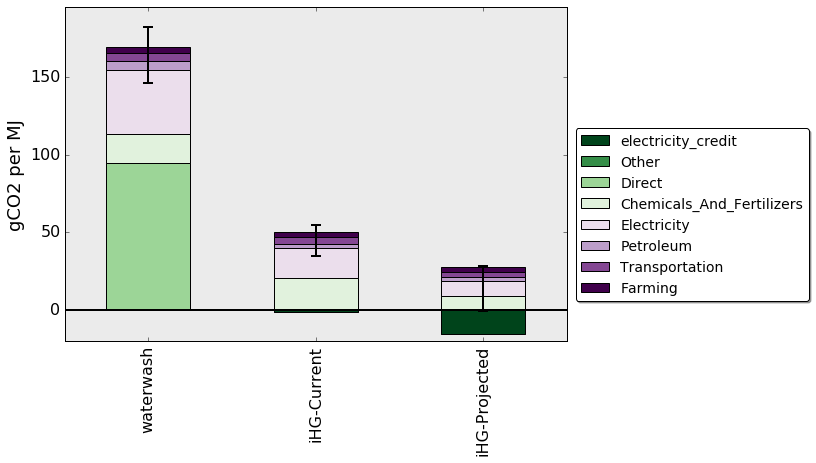

In [64]:

plot = aggregated_data_avg_plot.plot(kind='bar', stacked = True, figsize=(9,6),
                                     colormap='PRGn_r',
                                     yerr={'Farming':plt_errors}, 
                                     error_kw= {'capsize':5, 'ecolor':'k', 'elinewidth':2, 'capthick':2, 'barsabove':True})
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('gCO2 per MJ', fontsize = 18)
plt.ylim(-20,195)
plt.axhline(0, color='black', linewidth=2)
plot.set_axis_bgcolor("#EBEBEB")
plot.legend(loc='lower center', bbox_to_anchor=(1.25, 0.1),ncol=1, fancybox=True, shadow=True,fontsize=14)
with open('/Users/olga/Desktop/fig.html', 'w') as fn:
    fn.write(mpld3.fig_to_html(plt.gcf()))

In [61]:
mpld3.fig_to_html(plt.gcf())

u'\n\n<style>\n\n</style>\n\n<div id="fig_el5823844655726245692542047"></div>\n<script>\nfunction mpld3_load_lib(url, callback){\n  var s = document.createElement(\'script\');\n  s.src = url;\n  s.async = true;\n  s.onreadystatechange = s.onload = callback;\n  s.onerror = function(){console.warn("failed to load library " + url);};\n  document.getElementsByTagName("head")[0].appendChild(s);\n}\n\nif(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){\n   // already loaded: just create the figure\n   !function(mpld3){\n       \n       mpld3.draw_figure("fig_el5823844655726245692542047", {"axes": [], "height": 320.0, "width": 480.0, "plugins": [{"type": "reset"}, {"enabled": false, "button": true, "type": "zoom"}, {"enabled": false, "button": true, "type": "boxzoom"}], "data": {}, "id": "el582384465572624"});\n   }(mpld3);\n}else if(typeof define === "function" && define.amd){\n   // require.js is available: use it to load d3/mpld3\n   require.config({paths: {d3: "https://mpld3.github